# Notebook 05 — Erweiterter Modellansatz (HistGBR) und Hold-out Vergleich

Dieses Notebook adressiert die Anforderungen:

- **Anforderung 6:** Modellauswahl und Hyperparameter
- **Anforderung 7:** Training
- **Anforderung 8:** Evaluation und Ergebnisse (Hold-out)

Didaktische Einordnung im Projektfluss:
- Notebook 03/04 haben eine **Baseline ohne Leakage** etabliert und auf Hold-out evaluiert.
- In Notebook 05 erweitern wir den Ansatz um ein nichtlineares Modell (**HistGradientBoostingRegressor**) und vergleichen fair auf demselben Hold-out Split.

Wichtige Regel:
- `elapsed_time` ist im Datensatz vorhanden, wird aber **nicht** als Feature genutzt (Leakage-Risiko).

Outputs (lokal erzeugt):
- `data_derived/05_feature_set_histgbr.csv`
- `data_derived/05_histgbr_mini_tuning_results.csv` (optional)
- `data_derived/05_histgbr_selected_params.csv`
- `data_derived/05_holdout_metrics_histgbr.csv`
- `data_derived/05_holdout_predictions_histgbr.csv`
- `data_derived/05_holdout_comparison_baseline_vs_histgbr.csv`

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42
np.random.seed(SEED)

# Repository-Root robust bestimmen (funktioniert in /notebooks und im Repo-Root)
CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_DERIVED = REPO_ROOT / "data_derived"
PATH_PLOTS = REPO_ROOT / "plots"

PATH_DERIVED.mkdir(parents=True, exist_ok=True)
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

TARGET = "moving_time"

def rmse(y_true, y_pred) -> float:
    # versionsrobust (ohne squared-Parameter)
    return float(mean_squared_error(y_true, y_pred) ** 0.5)

def savefig(filename: str) -> None:
    out = PATH_PLOTS / filename
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")

print("REPO_ROOT:", REPO_ROOT)
print("PATH_MODEL_READY:", PATH_MODEL_READY)

# Steuerung: Dozent kann Run All schnell durchlaufen lassen
RUN_TUNING = False  # True = Mini-Tuning wird tatsächlich ausgeführt

# Default-Parameter (werden genutzt, wenn RUN_TUNING=False)
HGBR_BEST_PARAMS = {
    "max_depth": 6,
    "learning_rate": 0.03,
    "max_iter": 600,
}

REPO_ROOT: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer
PATH_MODEL_READY: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/model_ready.csv


In [2]:
if not PATH_MODEL_READY.exists():
    raise FileNotFoundError(
        "model_ready.csv nicht gefunden.\n"
        f"Erwarteter Pfad: {PATH_MODEL_READY}\n"
        "Bitte Notebook 02 ausführen."
    )

df = pd.read_csv(PATH_MODEL_READY)
print("model_ready geladen:", df.shape)

# Feature-Set für HistGBR (inkl. Feature Engineering aus Notebook 02)
FEATURES_HGBR = [
    "distance",
    "total_elevation_gain",
    "highest_elevation",
    "lowest_elevation",
    "distance_km",
    "elev_gain_per_km",
    "elev_range",
]

missing = [c for c in FEATURES_HGBR + [TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"Erwartete Spalten fehlen in model_ready.csv: {missing}")

X = df[FEATURES_HGBR].copy()
y = df[TARGET].astype(float).copy()

# Hold-out Split (muss identisch zu Notebook 04 bleiben)
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.20, random_state=SEED
)
print("Train:", X_train.shape, "Hold-out:", X_holdout.shape)

# Export: Feature-Set dokumentieren
feat_path = PATH_DERIVED / "05_feature_set_histgbr.csv"
pd.DataFrame({"feature": FEATURES_HGBR}).to_csv(feat_path, index=False)
print("Saved:", feat_path)

model_ready geladen: (9237, 13)
Train: (7389, 7) Hold-out: (1848, 7)
Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/05_feature_set_histgbr.csv


## Mini-Tuning (optional) und Parameterauswahl

Info:
- Der **Standardlauf** des Notebooks soll schnell durchlaufen: „Run All“ ohne Wartezeit.
- Gleichzeitig soll die **Herleitung** der gewählten HistGBR-Parameter nachvollziehbar sein.

Daher gilt:
- `RUN_TUNING = False` (Default): Wir überspringen die CV-Schleife und nutzen vordefinierte Parameter.
- `RUN_TUNING = True`: Wir führen ein kleines Grid-Tuning auf dem **Train-Split** per Cross-Validation aus.

Unabhängig davon wird immer eine Datei geschrieben:
- `data_derived/05_histgbr_selected_params.csv` (die Parameter, die im weiteren Verlauf verwendet werden)

In [3]:
from itertools import product

selected_path = PATH_DERIVED / "05_histgbr_selected_params.csv"
tuning_path = PATH_DERIVED / "05_histgbr_mini_tuning_results.csv"

if not RUN_TUNING:
    print("Mini-Tuning übersprungen (RUN_TUNING=False).")
    print("Verwendete Default-Parameter:", HGBR_BEST_PARAMS)

    selected = pd.DataFrame([{
        "max_depth": int(HGBR_BEST_PARAMS["max_depth"]),
        "learning_rate": float(HGBR_BEST_PARAMS["learning_rate"]),
        "max_iter": int(HGBR_BEST_PARAMS["max_iter"]),
        "source": "default_params (RUN_TUNING=False)"
    }])
    selected.to_csv(selected_path, index=False)
    print("Saved:", selected_path)

else:
    # Mini-Tuning bewusst kleiner halten (für Reproduzierbarkeit + Laufzeit)
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)

    grid = {
        "max_depth": [4, 6, 8],
        "learning_rate": [0.03, 0.05, 0.08],
        "max_iter": [300, 600],
    }

    rows = []
    for max_depth, learning_rate, max_iter in product(
        grid["max_depth"], grid["learning_rate"], grid["max_iter"]
    ):
        params = {
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "max_iter": max_iter,
            "random_state": SEED,
        }

        fold_mae, fold_rmse, fold_r2 = [], [], []

        for tr_idx, va_idx in kf.split(X_train):
            X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
            X_va, y_va = X_train.iloc[va_idx], y_train.iloc[va_idx]

            m = HistGradientBoostingRegressor(**params)
            m.fit(X_tr, y_tr)
            pred = m.predict(X_va)

            fold_mae.append(mean_absolute_error(y_va, pred))
            fold_rmse.append(rmse(y_va, pred))
            fold_r2.append(r2_score(y_va, pred))

        rows.append({
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "max_iter": max_iter,
            "mae_cv_mean_s": float(np.mean(fold_mae)),
            "mae_cv_std_s": float(np.std(fold_mae, ddof=1)) if len(fold_mae) > 1 else 0.0,
            "rmse_cv_mean_s": float(np.mean(fold_rmse)),
            "rmse_cv_std_s": float(np.std(fold_rmse, ddof=1)) if len(fold_rmse) > 1 else 0.0,
            "r2_cv_mean": float(np.mean(fold_r2)),
            "r2_cv_std": float(np.std(fold_r2, ddof=1)) if len(fold_r2) > 1 else 0.0,
        })

    tuning_results = (
        pd.DataFrame(rows)
        .sort_values("mae_cv_mean_s", ascending=True)
        .reset_index(drop=True)
    )
    display(tuning_results)

    tuning_results.to_csv(tuning_path, index=False)
    print("Saved:", tuning_path)

    best = tuning_results.iloc[0][["max_depth", "learning_rate", "max_iter"]].to_dict()
    best = {
        "max_depth": int(best["max_depth"]),
        "learning_rate": float(best["learning_rate"]),
        "max_iter": int(best["max_iter"]),
    }
    print("Best params (CV MAE auf Train):", best)

    selected = pd.DataFrame([{
        **best,
        "source": "mini_tuning_cv (RUN_TUNING=True)"
    }])
    selected.to_csv(selected_path, index=False)
    print("Saved:", selected_path)

    # wichtig: ab hier im Notebook diese Parameter verwenden
    HGBR_BEST_PARAMS = best

Mini-Tuning übersprungen (RUN_TUNING=False).
Verwendete Default-Parameter: {'max_depth': 6, 'learning_rate': 0.03, 'max_iter': 600}
Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/05_histgbr_selected_params.csv


## Training und Hold-out Evaluation (HistGBR)

Wir trainieren HistGBR auf dem Train-Split und evaluieren anschließend auf dem Hold-out Split (identisch zu Notebook 04).
Die verwendeten Hyperparameter werden aus `05_histgbr_selected_params.csv` geladen, sodass der weitere Verlauf unabhängig davon ist, ob das Mini-Tuning ausgeführt wurde oder nicht.

Exports:
- `data_derived/05_holdout_metrics_histgbr.csv`
- `data_derived/05_holdout_predictions_histgbr.csv`

In [4]:
# Parameter laden (single source of truth für dieses Notebook)
selected_path = PATH_DERIVED / "05_histgbr_selected_params.csv"
if not selected_path.exists():
    raise FileNotFoundError(
        "05_histgbr_selected_params.csv nicht gefunden.\n"
        f"Erwarteter Pfad: {selected_path}\n"
        "Bitte die Parameterauswahl-Zelle davor ausführen."
    )

sel = pd.read_csv(selected_path).iloc[0].to_dict()
HGBR_PARAMS = {
    "max_depth": int(sel["max_depth"]),
    "learning_rate": float(sel["learning_rate"]),
    "max_iter": int(sel["max_iter"]),
    "random_state": SEED,
}

model = HistGradientBoostingRegressor(**HGBR_PARAMS)
model.fit(X_train, y_train)

y_pred = model.predict(X_holdout)

mae = float(mean_absolute_error(y_holdout, y_pred))
rmse_val = float(rmse(y_holdout, y_pred))
r2 = float(r2_score(y_holdout, y_pred))

metrics_hist = pd.DataFrame([{
    "block": "Hold-out – Erweiterter Ansatz (HistGBR)",
    "model": f"HistGBR depth={HGBR_PARAMS['max_depth']} lr={HGBR_PARAMS['learning_rate']} it={HGBR_PARAMS['max_iter']}",
    "mae_s": mae,
    "rmse_s": rmse_val,
    "r2": r2,
    "mae_min": mae / 60.0,
    "rmse_min": rmse_val / 60.0,
}])

display(metrics_hist)

metrics_path = PATH_DERIVED / "05_holdout_metrics_histgbr.csv"
metrics_hist.to_csv(metrics_path, index=False)
print("Saved:", metrics_path)

pred_df = X_holdout.reset_index(drop=True).copy()
pred_df["y_true"] = y_holdout.reset_index(drop=True).astype(float)
pred_df["y_pred"] = pd.Series(y_pred).astype(float)
pred_df["abs_error_s"] = (pred_df["y_true"] - pred_df["y_pred"]).abs()

pred_path = PATH_DERIVED / "05_holdout_predictions_histgbr.csv"
pred_df.to_csv(pred_path, index=False)
print("Saved:", pred_path)
print("pred_df shape:", pred_df.shape)

print(f"Hold-out MAE: {mae:.2f}s ({mae/60:.2f} min) | RMSE: {rmse_val:.2f}s | R2: {r2:.4f}")

,block,model,mae_s,rmse_s,r2,mae_min,rmse_min
0,Hold-out – Erweiterter Ansatz (HistGBR),HistGBR depth=6 lr=0.03 it=600,605.110089,1452.820821,0.919316,10.085168,24.21368


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/05_holdout_metrics_histgbr.csv
Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/05_holdout_predictions_histgbr.csv
pred_df shape: (1848, 10)
Hold-out MAE: 605.11s (10.09 min) | RMSE: 1452.82s | R2: 0.9193


,baseline_model,baseline_mae_s,histgbr_model,histgbr_mae_s,mae_improvement_s,mae_improvement_pct
0,"Ridge (degree=1, alpha=0.01)",761.442789,HistGBR depth=6 lr=0.03 it=600,605.110089,156.3327,20.531116


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/05_holdout_comparison_baseline_vs_histgbr.csv


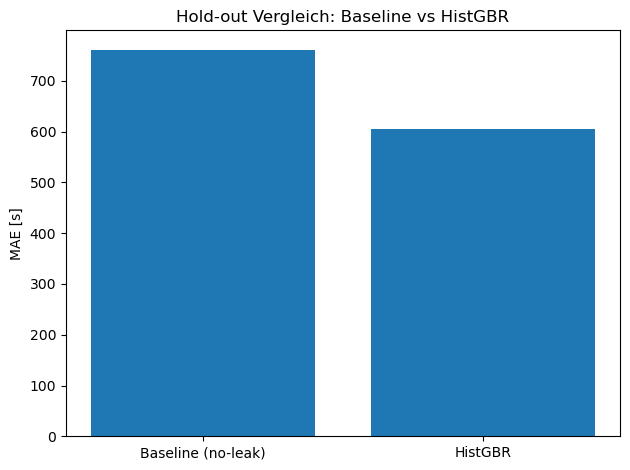

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/05_holdout_mae_comparison.png


In [5]:
baseline_path = PATH_DERIVED / "04_holdout_metrics_no_leak.csv"
if not baseline_path.exists():
    raise FileNotFoundError(
        "Baseline-Metriken nicht gefunden.\n"
        f"Erwarteter Pfad: {baseline_path}\n"
        "Bitte Notebook 04 ausführen (Hold-out Evaluation Baseline)."
    )

baseline = pd.read_csv(baseline_path).iloc[0].to_dict()
baseline_mae = float(baseline["mae_s"])
baseline_model = str(baseline["model"])

hist_row = metrics_hist.iloc[0].to_dict()
hist_mae = float(hist_row["mae_s"])
hist_model = str(hist_row["model"])

comp = pd.DataFrame([{
    "baseline_model": baseline_model,
    "baseline_mae_s": baseline_mae,
    "histgbr_model": hist_model,
    "histgbr_mae_s": hist_mae,
    "mae_improvement_s": baseline_mae - hist_mae,
    "mae_improvement_pct": (baseline_mae - hist_mae) / baseline_mae * 100.0,
}])

display(comp)

comp_path = PATH_DERIVED / "05_holdout_comparison_baseline_vs_histgbr.csv"
comp.to_csv(comp_path, index=False)
print("Saved:", comp_path)

# Plot: MAE Vergleich (Hold-out)
plot_df = pd.DataFrame([
    {"modell": "Baseline (no-leak)", "mae_s": baseline_mae},
    {"modell": "HistGBR", "mae_s": hist_mae},
]).sort_values("mae_s", ascending=False)

plt.figure()
plt.bar(plot_df["modell"], plot_df["mae_s"])
plt.ylabel("MAE [s]")
plt.title("Hold-out Vergleich: Baseline vs HistGBR")
savefig("05_holdout_mae_comparison.png")
plt.show()

print("Saved:", PATH_PLOTS / "05_holdout_mae_comparison.png")

## Ergebnis und Einordnung

Der erweiterte Ansatz (HistGBR) verbessert die Vorhersage auf dem Hold-out deutlich gegenüber der Baseline (no-leak):

- **Baseline (Ridge, degree=1, alpha=0.01):** MAE ≈ 761 s  
- **HistGBR (depth=6, lr=0.03, it=600):** MAE ≈ 605 s  
- **Verbesserung:** ≈ 156 s (≈ 20.5%)

Interpretation:
- HistGBR kann nichtlineare Zusammenhänge abbilden (z. B. unterschiedliche Effekte von Steigung/Profil je nach Distanz) und profitiert daher vom Feature Engineering aus Notebook 02.
- Der Vergleich ist fair, weil beide Modelle auf **demselben Hold-out Split** evaluiert werden und `elapsed_time` nicht als Feature genutzt wird.

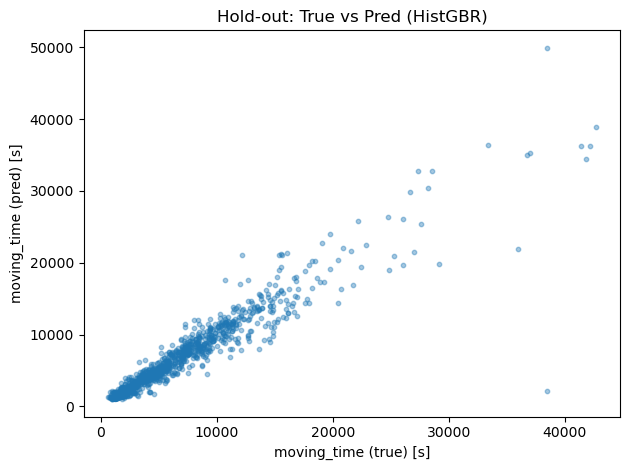

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/05_holdout_true_vs_pred_histgbr.png


In [6]:
plt.figure()
plt.scatter(pred_df["y_true"], pred_df["y_pred"], s=10, alpha=0.4)
plt.xlabel("moving_time (true) [s]")
plt.ylabel("moving_time (pred) [s]")
plt.title("Hold-out: True vs Pred (HistGBR)")
savefig("05_holdout_true_vs_pred_histgbr.png")
plt.show()

print("Saved:", PATH_PLOTS / "05_holdout_true_vs_pred_histgbr.png")

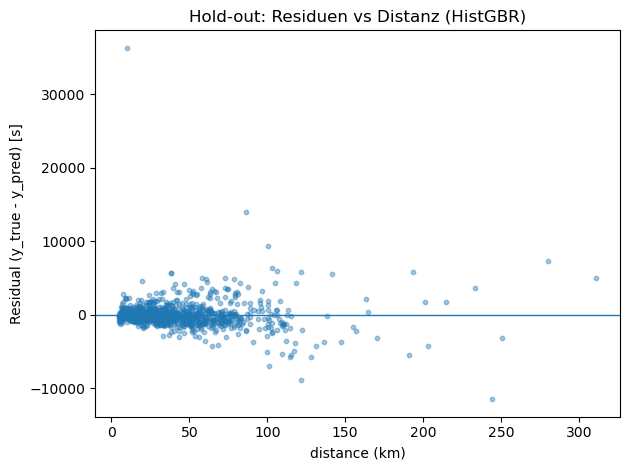

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/05_holdout_residuals_vs_distance_histgbr.png


In [7]:
residuals = pred_df["y_true"] - pred_df["y_pred"]

plt.figure()
plt.scatter(pred_df["distance_km"], residuals, s=10, alpha=0.4)
plt.axhline(0, linewidth=1)
plt.xlabel("distance (km)")
plt.ylabel("Residual (y_true - y_pred) [s]")
plt.title("Hold-out: Residuen vs Distanz (HistGBR)")
savefig("05_holdout_residuals_vs_distance_histgbr.png")
plt.show()

print("Saved:", PATH_PLOTS / "05_holdout_residuals_vs_distance_histgbr.png")

## Abschluss

Notebook 05 hat den Baseline-Ansatz um HistGBR erweitert und den Vergleich auf einem festen Hold-out Split durchgeführt.
Die verwendeten Parameter sind über `05_histgbr_selected_params.csv` dokumentiert; alle Exporte werden lokal erzeugt und dienen als Input für Notebook 06 (Interpretierbarkeit) und Notebook 08 (Final Report).

In [8]:
artifacts_05 = [
    PATH_DERIVED / "05_feature_set_histgbr.csv",
    PATH_DERIVED / "05_histgbr_selected_params.csv",
    PATH_DERIVED / "05_holdout_metrics_histgbr.csv",
    PATH_DERIVED / "05_holdout_predictions_histgbr.csv",
    PATH_DERIVED / "05_holdout_comparison_baseline_vs_histgbr.csv",
    PATH_PLOTS / "05_holdout_mae_comparison.png",
    PATH_PLOTS / "05_holdout_true_vs_pred_histgbr.png",
    PATH_PLOTS / "05_holdout_residuals_vs_distance_histgbr.png",
]

report = pd.DataFrame([{
    "artifact": p.as_posix(),
    "exists": p.exists(),
} for p in artifacts_05])

display(report)

,artifact,exists
0,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
1,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
2,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
3,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
4,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
5,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
6,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
7,/Users/justuspfeifer/Documents/AML/aml-justus-...,True
